## Deep Learning Capstone Project
## Facial Emotion Detection
Jeff Stearns

# <span style="color:black">Problem Definition</span>

**Context:**<br>
The analysis of human facial expressions using Artificial Intelligence can potentially provide a better understanding of human behavior. AI emotion detection can also potentially assist security such as airport and police in identifying potential threats in a particular setting. Facial expression conveys valuable non verbal communication cues.

**Objective:**<br>
This project utilizes the power of Convolutional Neural Networks (CNN) to create models capable of classification of images into four categories of facial expressions: Happy, sad, neutral and surprise. The dataset provided for this project, Facial_emotion_images.zip, contains 20,000+ grayscale images split into training, validation and test datasets. All images are 48 pixel squares, a low resolution dataset.

A high level view of the CNN model development for this project is to develop two preliminary grayscale/RGB CNN models, followed by three Transfer Learning CNNs (VGG16, ResNetv2 and EfficientNet) and finally attempt to improve upon the afore mentioned CNNs by experimenting with additional CNN layers, numbers of neurons, pooling layers, flattening, batchnormalization and dropout layers.

**Key Questions:**<br>
* How do our base CNN models compare with Transfer learning models of greater complexity?
* Can we improve on our base CNN models through trial and error?
* Is the dataset good enough in both quantity and quality?
* Average natural human ability to detect emotions is around 90%, can we approach this level?
* Are there any ethical issues with CNN/AI facial emotion detection or is it innocuous because it does not involve identity?
* Is the final model for the Capstone project good enough for deployment?




## **About the Dataset**

The data set consists of 3 folders, i.e., 'test', 'train', and 'validation'.
Each of these folders has four subfolders:

**‘happy’**: Images of people who have happy facial expressions.<br>
**‘sad’**: Images of people with sad or upset facial expressions.<br>
**‘surprise’**: Images of people who have shocked or surprised facial expressions.<br>
**‘neutral’**: Images of people showing no prominent emotion in their facial expression at all.<br>

## **Importing the Libraries**

In [ ]:
# Used to unzip the source data
import zipfile

import numpy as np                    # Mathematical functions, arrays, etc.
import pandas as pd                   # Data manipulation and analysis
import os                             # Misc operating system interfaces
import h5py                           # Read and write h5py files
import random

import matplotlib.pyplot as plt       # A library for data visualization
from matplotlib import image as mpimg # Used to show images from filepath
import seaborn as sns                 # An advanced library for data visualization
from PIL import Image                 # Image processing
#import cv2                            # Image processing

# Importing Deep Learning Libraries, layers, models, optimizers, etc
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D, BatchNormalization, Activation, MaxPooling2D, LeakyReLU, GaussianNoise
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
import tensorflow.keras.applications as ap
from tensorflow.keras.applications.vgg16 import VGG16
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras import backend
import tensorflow as tf

# Sci-Kit Learn : Predictive data analysis
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# To suppress warnings
#import warnings
#warnings.filterwarnings("ignore")


In [2]:
# Fixing the seed for random number generators
np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

### **Loading and Unzipping the Data**

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Path to Facial Library ZIP File in Google drive
face_file = '/content/drive/MyDrive/MITAppliedDataScience/FacialRecognition/Facial_emotion_images.zip'

# Extracting image files from the zip file
with zipfile.ZipFile(face_file, "r") as zip_ref:
    zip_ref.extractall()

# Setup subdirectory pointers
train_dir = "Facial_emotion_images/train/"
validation_dir = "Facial_emotion_images/validation/"
test_dir = "Facial_emotion_images/test/"
# Size of images in dataset is 48 pixels square
img_size = 48

Mounted at /content/drive


## **Visualizing our Classes**


In [5]:
# Display first 16 images from the specified training folder
def get_image(emotion):
    train_emotion = train_dir + emotion + "/"
    plt.figure(figsize = (10, 10))

    for i in range(1, 17):
        plt.subplot(4, 4, i)
        img = load_img(train_emotion +
                    os.listdir(train_emotion)[i],
                    target_size = (img_size, img_size))
        plt.imshow(img)

    plt.show()

### **Happy**

First 16 training images labeled as 'Happy':


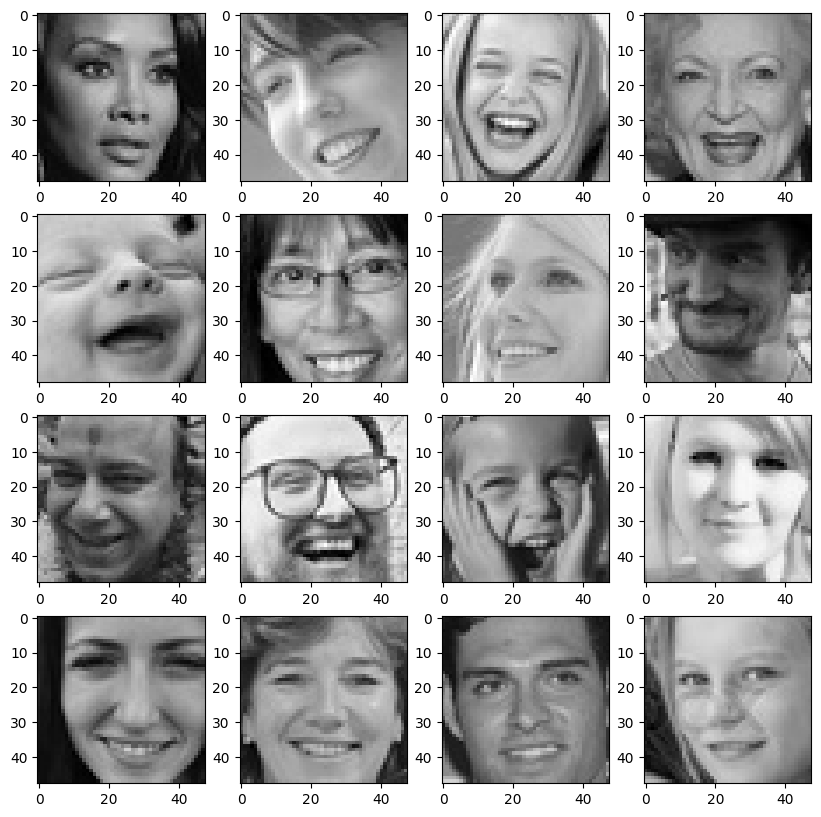

In [6]:
print("First 16 training images labeled as 'Happy':")
get_image("happy")

**Observations - Happy**<br>
* Generally face is smiling, sometimes with teeth visible.
* Images without a face observed, "fixed" dataset may be generated in final analysis.
* Some images are questionable in terms of illustrating happy, missed predictions will be analyzed.
* Some images contain hats, eyeglasses, hands blocking part of face and watermarks. Models will need to handle these issues.
* Data augmentation is required for rotated and tilted images.

### **Sad**

First 16 training images labeled as 'Sad':


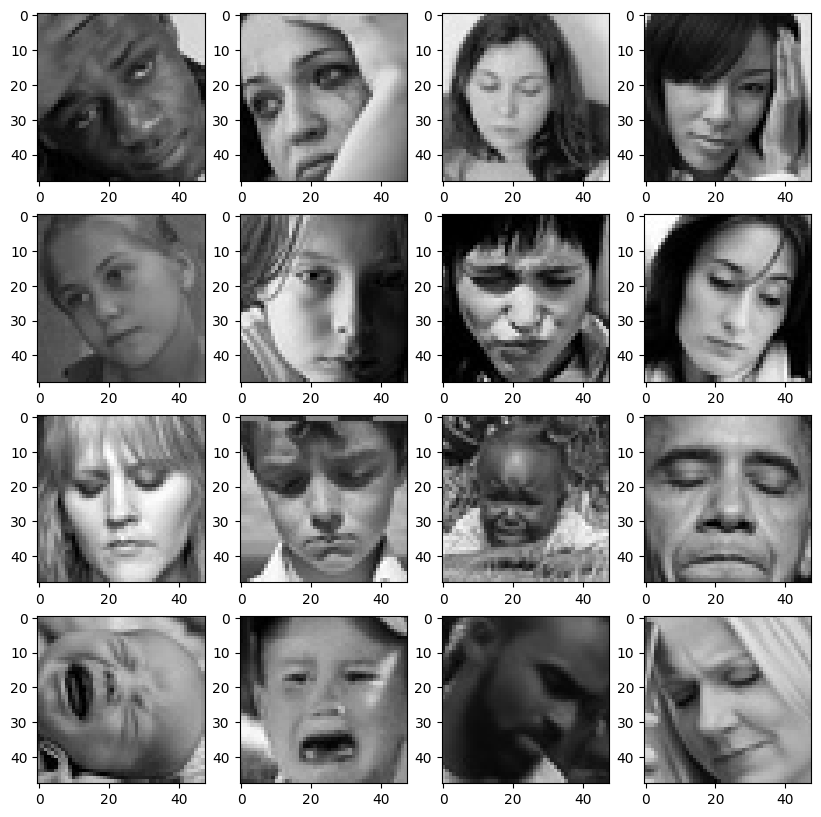

In [7]:
print("First 16 training images labeled as 'Sad':")
get_image("sad")

**Observations - Sad**<br>
* Generally face is frowning.
* Eyes are often closed.
* As with 'happy' dataset, some images appear to be mischaracterized.
* Despite low resolution of images, clear distinction exists between happy and sad images in general.

### **Neutral**

First 16 training images labeled as 'Neutral':


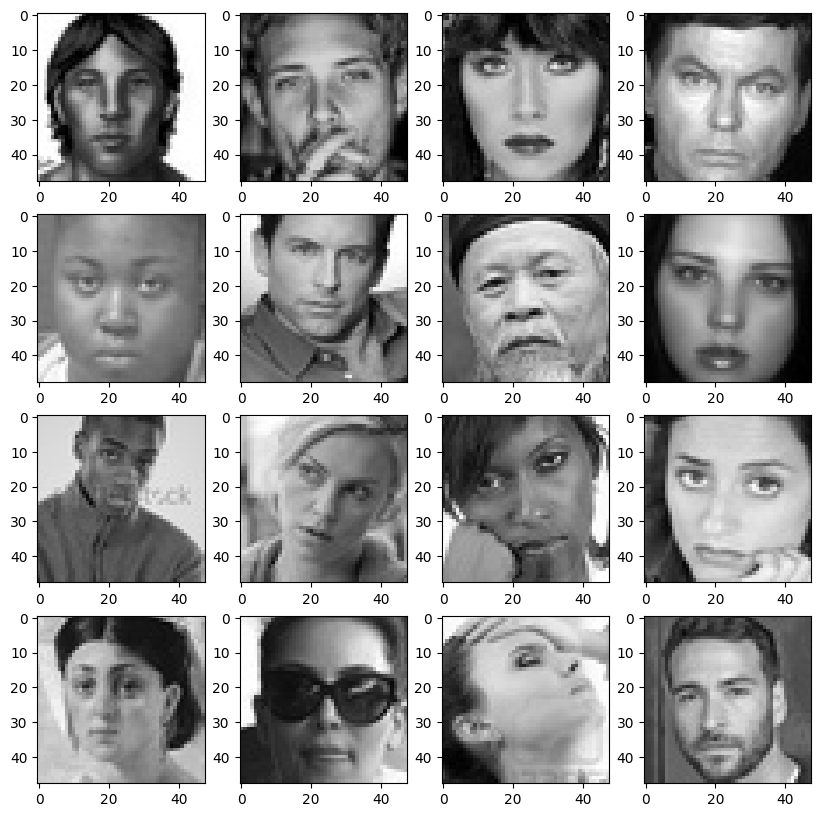

In [8]:
print("First 16 training images labeled as 'Neutral':")
get_image("neutral")

**Observations - Neutral**<br>
* Neutral images are generally less distinctive in terms of detectable edges or features compared to other classes.
* Lips straight, not tilted up or down is perhaps the most distinctive feature.
* Mischaracterized and images without faces also exist in this dataset.

### **Surprise**

First 16 training images labeled as 'Surprise':


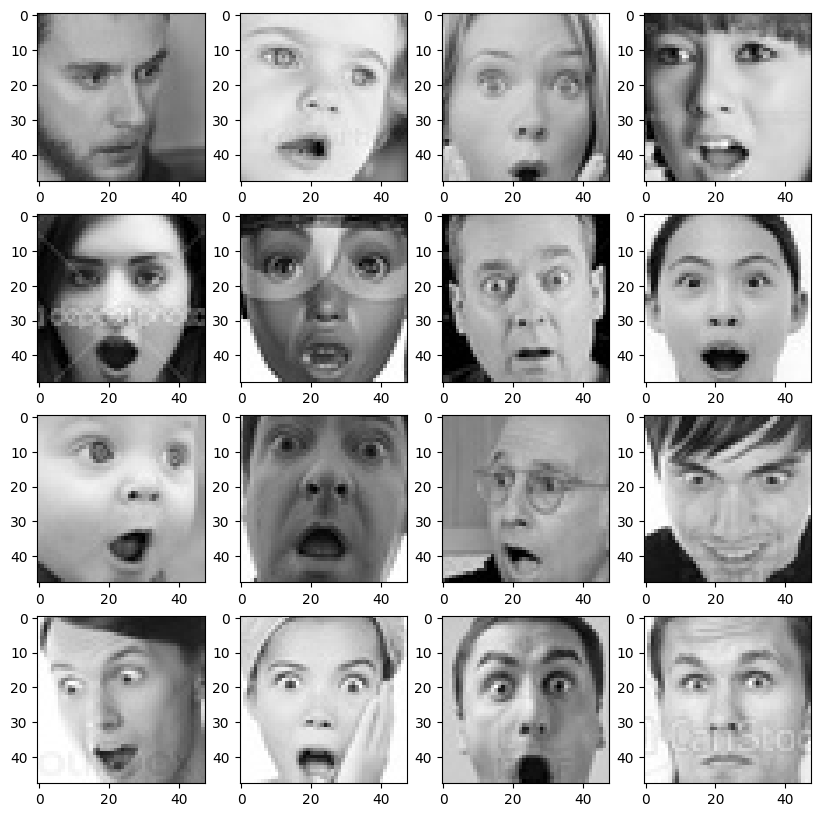

In [9]:
print("First 16 training images labeled as 'Surprise':")
get_image("surprise")

**Observations - Surprise**<br>
* Readily detectable features include open mouths and wide eyes. Not every image includes these features but it is common.
* As with other categories, some images do not contain faces or are mischaracterized.

## **Class Distributions**

In [10]:
# Getting the count of images in each training folder and saving to variables

train_happy = len(os.listdir(train_dir + "happy/"))
train_sad = len(os.listdir(train_dir + "sad/"))
train_neutral = len(os.listdir(train_dir + "neutral/"))
train_surprised = len(os.listdir(train_dir + "surprise/"))

# Creating a Pandas series called "train_series" and converting to Pandas dataframe called "train_df"
# in order to display the table below. The dataframe will also contribute to bar charts farther below.
train_series = pd.Series({'Happy': train_happy, 'Sad': train_sad, 'Neutral': train_neutral,
                          'Surprised': train_surprised})
train_df = pd.DataFrame(train_series, columns = ['Total Training Images'])
train_df["Percentage"] = round((train_df["Total Training Images"] / train_df["Total Training Images"].sum())*100, 1)
train_df.index.name='Emotions'

print("The distribution of classes within the training data:")
train_df

The distribution of classes within the training data:


,Total Training Images,Percentage
Emotions,,
Happy,3976,26.3
Sad,3982,26.4
Neutral,3978,26.3
Surprised,3173,21.0


In [11]:
train_df.sum()

Total Training Images    15109.0
Percentage                 100.0
dtype: float64

**Observations: Training Images**<br>
* There are 15,109 training images in total.
* Happy, sad, and neutral images make up roughly the same share of total training images (26%), while surprise images make up a smaller share (21%). At this stage it is important to note the relatively small imbalance, though the ratio does not seem skewed enough to warrant future manipulation in terms of weights, etc.
* The insight made above, that surprise images seem to be some of the most unique in terms of characteristics (big open mouth, big open eyes), may actually help us overcome the relatively minor imbalance. There are fewer surprise images, but they may be easier to classify.



In [12]:
# Getting count of images in each validation folder and saving to variables

val_happy = len(os.listdir(validation_dir + "happy/"))
val_sad = len(os.listdir(validation_dir + "sad/"))
val_neutral = len(os.listdir(validation_dir + "neutral/"))
val_surprised = len(os.listdir(validation_dir + "surprise/"))

# Creating a Pandas series called "val_series" and converting to Pandas dataframe called "val_df"
# in order to display the table below. The dataframe will also contribute to bar charts farther below.

val_series = pd.Series({'Happy': val_happy, 'Sad': val_sad, 'Neutral': val_neutral,
                        'Surprised': val_surprised})
val_df = pd.DataFrame(val_series, columns = ['Total Validation Images'])
val_df["Percentage"] = round((val_df["Total Validation Images"] / val_df["Total Validation Images"].sum())*100, 1)
val_df.index.name='Emotions'

print("The distribution of classes within the validation data:")
val_df

The distribution of classes within the validation data:


,Total Validation Images,Percentage
Emotions,,
Happy,1825,36.7
Sad,1139,22.9
Neutral,1216,24.4
Surprised,797,16.0


In [13]:
val_df.sum()

Total Validation Images    4977.0
Percentage                  100.0
dtype: float64

**Observations: Validation Images**<br>
* There are 4,977 validation images in total.
* The distribution across classes is much more imbalanced. Happy images make up almost 37% of total validation images, while surprise images make up only 16%. As the training images and validation images are already split and provided as is, it is not a simple matter of randomly splitting training data with a train/test split. We are stuck with the imbalance.
* One solution to address the imbalance could be to cap the other classes at the level of the surprise class, but that would throw away a huge portion of our already small data set.
* As mentioned above, we can surmise that surprise images are easier to classify because of their unique characteristics, and we will see if that is enough to offset the relatively smaller sample size with which to train and validate.


In [14]:
# Getting count of images in each test folder and saving to variables

test_happy = len(os.listdir(test_dir + "happy/"))
test_sad = len(os.listdir(test_dir + "sad/"))
test_neutral = len(os.listdir(test_dir + "neutral/"))
test_surprised = len(os.listdir(test_dir + "surprise/"))

# Creating a Pandas series called "test_series" and converting to Pandas dataframe called "test_df"
# in order to display the table below. The dataframe will also contribute to bar charts farther below.

test_series = pd.Series({'Happy': test_happy, 'Sad': test_sad, 'Neutral': test_neutral,
                        'Surprised': test_surprised})
test_df = pd.DataFrame(test_series, columns = ['Total Test Images'])
test_df["Percentage"] = round((test_df["Total Test Images"] / test_df["Total Test Images"].sum())*100, 1)
test_df.index.name='Emotions'

print("The distribution of classes within the validation data:")
test_df

The distribution of classes within the validation data:


,Total Test Images,Percentage
Emotions,,
Happy,32,25.0
Sad,32,25.0
Neutral,32,25.0
Surprised,32,25.0


In [15]:
test_df.sum()

Total Test Images    128.0
Percentage           100.0
dtype: float64

**Observations: Test Images**<br>
* There are 128 test images in total, evenly divided between all four classes.
* This even distribution will make interpretation of the final confusion matrix very straightforward.

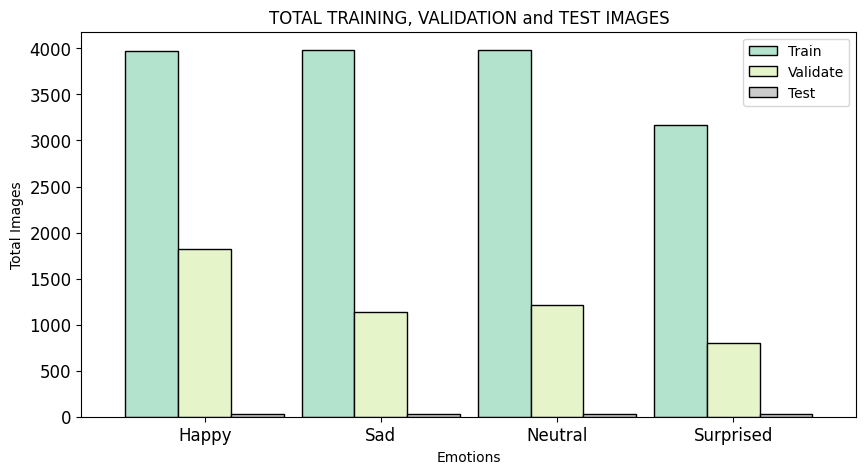

In [16]:
# Concatenating train_df, val_df, and test_df to create "df_total" in order to create the chart below

df_total = pd.concat([train_df, val_df, test_df], axis=1)
df_total.drop(['Percentage'], axis=1, inplace=True)
df_total = df_total.reset_index()
df_total.rename(columns={"index":"Emotions", "Total Training Images":"Train",
                   "Total Validation Images":"Validate", "Total Test Images":"Test"}, inplace=True)

# Creating bar chart below, grouped by class (i.e. 'emotion') and broken down into "train", "validate",
# and "test" data. The x-axis is Emotions and the y-axis is Total Images.

df_total.groupby("Emotions", sort=False).mean().plot(kind='bar', figsize=(10,5),
                            title="TOTAL TRAINING, VALIDATION and TEST IMAGES",
                            ylabel="Total Images", rot=0, fontsize=12, width=0.9, colormap="Pastel2",
                            edgecolor='black')
plt.show()

**Observations:**<br>
* Depicted graphically, the distribution of classes is clearly imbalanced, but the imbalance is not overpowering.
* Perhaps most striking is the tiny proportion of test images compared to training images. Rather than a standard machine learning train/validation/test split of 80/10/10 or 70/20/10, the data as provided for this project is 75% training, 24.5% validation, and just 0.5% test. As the data is provided already split into groups, we will work as intended. The vast majority of data will be used to train and then validate our models, with a tiny proportion used for testing. This should work in our favor, maximizing the amount of data used by our models to train.


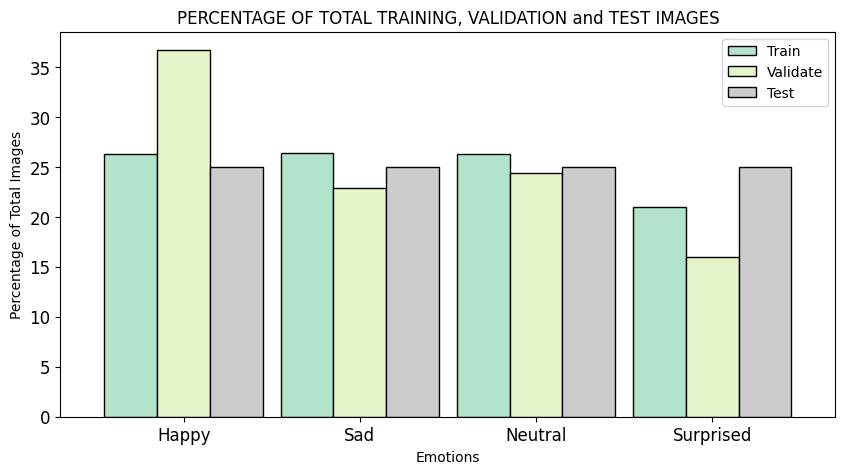

In [17]:
# Concatenating train_df, val_df, and test_df to create "df_percent" in order to create the chart below

df_percent = pd.concat([train_df, val_df, test_df], axis=1)
df_percent.drop(['Total Training Images', 'Total Validation Images', 'Total Test Images'], axis=1, inplace=True)
df_percent.columns = ["Train", "Validate", "Test"]

# Creating bar chart below, grouped by class (i.e. 'emotion') and broken down into "train", "validate",
# and "test" data. The x-axis is Emotions and the y-axis is Percentage of Total Images.

df_percent.groupby("Emotions", sort=False).mean().plot(kind='bar', figsize=(10,5),
                            title="PERCENTAGE OF TOTAL TRAINING, VALIDATION and TEST IMAGES",
                            ylabel="Percentage of Total Images", rot=0, fontsize=12, width=0.9, colormap="Pastel2",
                            edgecolor='black')
plt.show()

**Observations:**
* A visual depiction of what was discussed earlier. We can see the percentage breakdown of train/validate/test data across classes.
* Training data is evenly distributed across happy, sad, and neutral classes, with fewer surprise images.
* Within the validation data set, happy images clearly make up the largest percent of total images, with surprise images coming in a distant last place.
* Happy images make up a much larger percentage of the validation data set than they do of the training and test data sets.
* Surprise images make up a larger percentage of the test data set than they do of the training and validation data sets.

**Note:**<br>
Data pre-processing and augmentation will take place during the creation of data loaders. When ImageDataGenerator objects are instantiated, a range of processes can and will be applied, sometimes to varying degrees, depending on the model being created and trained. Some process/augmentation operations include the following:<br>
* **rotation_range** allows us to provide a degree range for random rotations of images. This helps address the issue of faces in the training images being tilted in different directions.
* **height_shift_range** allows us to shift the image up and down.
* **width_shift_range** allows us to shift the image left and right.
* **brightness_range** allows us to address the wide range in pixel values from one image to the next. A number smaller than one makes an image darker, and a number larger than one makes an image lighter.
* **shear_range** allows us to shear angle in a counter-clockwise direction.
* **zoom_range** allows us to zoom in or out, essentially randomly cropping the images.
* **horizontal_flip** allows us to flip the training image so it is a mirror image of itself. An image facing left will now face right, etc.
* **rescale** is our opportunity to normalize the input image from a tensor filled with numbers from 0 to 255, down to a tensor of numbers ranging from 0 to 1.

While creating our data sets via **flow_from_directory**, we have an opportunity to set class_mode to 'categorical', which will essentially one-hot-encode our classes. The classes themselves are then defined as 'happy,' 'sad,' 'neutral,' and 'surprise.' This allows us to set our loss to **categorical_crossentropy**, which itself is used for multi-class classification where each image (in our case) belongs to a single class.

## **Creating Data Loaders**

During Capstone project development Grayscale and RGB were both run with the same setup. Results were very similar so RGB was dropped from the project due to no value added.


In [20]:
batch_size  = 32

# Grayscale Colormode ImageDataGenerator method
datagen_train_grayscale = ImageDataGenerator(horizontal_flip = True,
                                             brightness_range = (0.,2.),
                                             rescale = 1./255,
                                             shear_range = 0.3)

datagen_validation_grayscale = ImageDataGenerator(horizontal_flip = True,
                                                  brightness_range = (0.,2.),
                                                  rescale = 1./255,
                                                  shear_range = 0.3)

datagen_test_grayscale = ImageDataGenerator(horizontal_flip = True,
                                            brightness_range = (0.,2.),
                                            rescale = 1./255,
                                            shear_range = 0.3)

# Sets for colormode for train, validation, and test sets

train_set_grayscale = datagen_train_grayscale.flow_from_directory(train_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        seed = 42,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        shuffle = True)

val_set_grayscale = datagen_validation_grayscale.flow_from_directory(validation_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        seed = 42,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        shuffle = False)

test_set_grayscale = datagen_test_grayscale.flow_from_directory(test_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        seed = 42,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        shuffle = False)



Grayscale Images
Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


**Note:**<br>
Data augmentation performed on the data for these initial models includes **horizontal_flip**, **brightness_range**, **rescale**, and **shear_range**.

## **Model Building**

**A Note About Neural Networks:**<br>
The best algorithmic tools we have available to us for processing images are neural networks. In particular, convolutional neural networks (CNN) have significant advantages over standard artificial neural networks (ANN).<br>

While image classification utilizing ANNs is possible, there are some drawbacks:
* **Translational Invariance:** ANNs are not translation invariant, meaning that the location of objects within the image is learned along with the object itself. If the object is located in different areas of the image, varying from image to image, the ANN will likely produce inconsistent results.
* **Spacial Invariance:** ANNs are not spatial invariant, meaning that once the image matrix is converted/flattened into an array, they lose spatial information about the image. In reality, nearby pixels within an image should be more strongly related to one another, but an ANN does not leverage this information.
* **Feature Extraction:** ANNs give similar importance to each pixel within an image, meaning that they are learning the background of the image to the same degree that they are learning the object within the image. If the background changes from image to image, the ANN will have a difficult time learning that the object itself is the same despite what is going on in the background of the image.
* **Computational Expense:** ANNs need input images to be flattened into an array of pixel values, and as the input images get larger and the number of hidden layers increases, the total number of trainable parameters balloons considerably.

On the other hand, through the use of convolutional and pooling layers, CNNs are translationally and spatially invariant. They are able to understand that the location of an object within an image is not important, nor is the background of the image itself. CNNs, through the use of their convolutional layers, are also better able to extract important features of an object within an image. Finally, CNNs take advantage of weight sharing, as the same filters are applied to each area of the image. This reduces the number of weights that need to be learned through backpropagation, thereby minimizing the number of trainable parameters and reducing computational expense.  <br>

Taking all of this into account, we will proceed with the development of CNN models to pursue our objectives.


## <span style="color:navy">Model 1: Base Neural Network (Grayscale)</span>

**Note:**<br>
We will begin by building a simple CNN model to serve as a baseline for future models. The same model will be built with color_mode set to grayscale (with an input shape of 48,48,1) as well as color_mode set to RGB (with an input shape of 48,48,3). The models will then be compared to determine if one approach outperforms the other. <br><br>
A baseline grayscale model is developed first. It consists of three convolutional blocks with relu activation, MaxPooling and a Dropout layer, followed by a single dense layer with 512 neurons, and a softmax classifier for multi-class classification. Total trainable parameters are 605,060.

In [21]:
# Creating a Sequential model
cnn1_gray = Sequential()

# Convolutional Block #1
cnn1_gray.add(Conv2D(64, (2, 2), input_shape = (48, 48, 1), activation='relu', padding = 'same'))
cnn1_gray.add(MaxPooling2D(2, 2))
cnn1_gray.add(Dropout(0.2))

# Convolutional Block #2
cnn1_gray.add(Conv2D(32, (2, 2), activation='relu', padding = 'same'))
cnn1_gray.add(MaxPooling2D(2, 2))
cnn1_gray.add(Dropout(0.2))

# Convolutional Block #3
cnn1_gray.add(Conv2D(32, (2, 2), activation='relu', padding = 'same'))
cnn1_gray.add(MaxPooling2D(2, 2))
cnn1_gray.add(Dropout(0.2))

# Flatten layer
cnn1_gray.add(Flatten())

# Dense layer
cnn1_gray.add(Dense(512, activation = 'relu'))

# Classifier
cnn1_gray.add(Dense(4, activation = 'softmax'))

cnn1_gray.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 32)        8224      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 12, 12, 32)        0

### **Compiling and Training the Model**


In [22]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint("./cnn1_gray.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [23]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
cnn1_gray.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [24]:
# Fitting model with epochs set to 30
#history_1_grayscale = cnn1_gray.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 30, callbacks = callbacks_list)
history_1_grayscale = cnn1_gray.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 3, callbacks = callbacks_list)

Epoch 1/3
473/473 [==============================] - ETA: 0s - loss: 1.3107 - accuracy: 0.3591
Epoch 1: val_accuracy improved from -inf to 0.48101, saving model to ./cnn1_gray.h5
473/473 [==============================] - 90s 187ms/step - loss: 1.3107 - accuracy: 0.3591 - val_loss: 1.2052 - val_accuracy: 0.4810 - lr: 0.0010
Epoch 2/3
473/473 [==============================] - ETA: 0s - loss: 1.1743 - accuracy: 0.4790
Epoch 2: val_accuracy improved from 0.48101 to 0.53104, saving model to ./cnn1_gray.h5
473/473 [==============================] - 77s 162ms/step - loss: 1.1743 - accuracy: 0.4790 - val_loss: 1.1055 - val_accuracy: 0.5310 - lr: 0.0010
Epoch 3/3
473/473 [==============================] - ETA: 0s - loss: 1.0860 - accuracy: 0.5215
Epoch 3: val_accuracy improved from 0.53104 to 0.56259, saving model to ./cnn1_gray.h5
473/473 [==============================] - 75s 157ms/step - loss: 1.0860 - accuracy: 0.5215 - val_loss: 1.0126 - val_accuracy: 0.5626 - lr: 0.0010


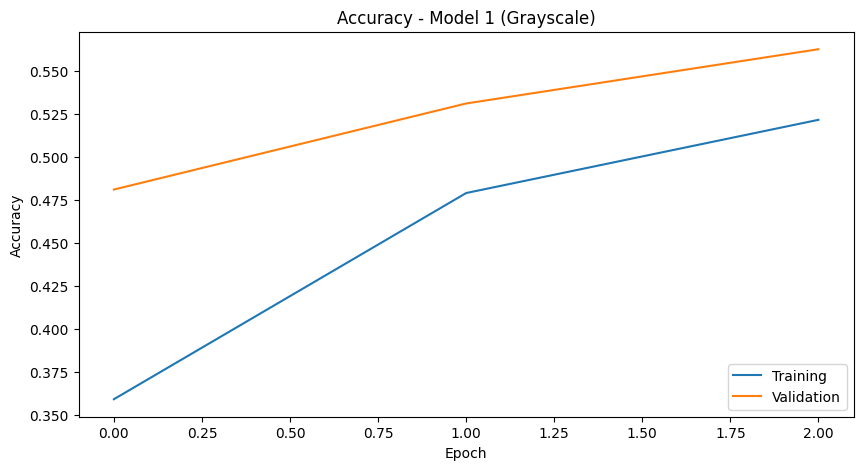

In [25]:
# Plotting the accuracies

plt.figure(figsize = (10, 5))
plt.plot(history_1_grayscale.history['accuracy'])
plt.plot(history_1_grayscale.history['val_accuracy'])
plt.title('Model Accuracy - Grayscale1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [27]:
# Evaluating the model's performance on the test set
accuracy = cnn1_gray.evaluate(test_set_grayscale)

4/4 [==============================] - 0s 39ms/step - loss: 0.9742 - accuracy: 0.5625


**Observations and Insights:**<br>
As constructed, our baseline grayscale model performs decently. After 28 epochs (best epoch), training accuracy stands at 0.68 and validation accuracy is 0.68. Training accuracy and loss continue to improve, while validation accuracy and loss begin to level off before early-stopping ends the training process. Accuracy on the test set is 0.625. A glance at the results, and the accuracy/loss graphs above, reveals a model that is overfitting and consequently has some room for improvement.

|  | Training | Validation | Test |
| --- | --- | --- | --- |
|  Grayscale Accuracy |0.68 | 0.68 | 0.625 |
<br>




## <span style="color:navy">Model 2: Grayscale</span>


**Note:**<br>
We will now build a slightly deeper model to see if we can improve performance. Similar to our baseline models, we will train this model with color_modes of grayscale and RGB so we can compare performance. <br>

The architecture of our second model is comprised of 4 convolutional blocks with relu activation, BatchNormalization, a LeakyReLu layer, and MaxPooling, followed by a dense layer with 512 neurons, another dense layer with 256 neurons, and finally a softmax classifier. The grayscale model has a total of 455,780 parameters.



In [28]:
# Creating a Sequential model
cnn2_gray = Sequential()

# Convolutional Block #1
cnn2_gray.add(Conv2D(256, (2, 2), input_shape = (48, 48, 1), activation='relu', padding = 'same'))
cnn2_gray.add(BatchNormalization())
cnn2_gray.add(LeakyReLU(alpha = 0.1))
cnn2_gray.add(MaxPooling2D(2, 2))

# Convolutional Block #2
cnn2_gray.add(Conv2D(128, (2, 2), activation='relu', padding = 'same'))
cnn2_gray.add(BatchNormalization())
cnn2_gray.add(LeakyReLU(alpha = 0.1))
cnn2_gray.add(MaxPooling2D(2, 2))

# Convolutional Block #3
cnn2_gray.add(Conv2D(64, (2, 2), activation='relu', padding = 'same'))
cnn2_gray.add(BatchNormalization())
cnn2_gray.add(LeakyReLU(alpha = 0.1))
cnn2_gray.add(MaxPooling2D(2, 2))

# Convolutional Block #4
cnn2_gray.add(Conv2D(32, (2, 2), activation='relu', padding = 'same'))
cnn2_gray.add(BatchNormalization())
cnn2_gray.add(LeakyReLU(alpha = 0.1))
cnn2_gray.add(MaxPooling2D(2, 2))

# Flatten layer
cnn2_gray.add(Flatten())

# Dense layers
cnn2_gray.add(Dense(512, activation = 'relu'))
cnn2_gray.add(Dense(256, activation = 'relu'))

# Classifier
cnn2_gray.add(Dense(4, activation = 'softmax'))

cnn2_gray.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 48, 48, 256)       1280      
                                                                 
 batch_normalization (Batch  (None, 48, 48, 256)       1024      
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 48, 48, 256)       0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 24, 24, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 24, 24, 128)       131200    
                                                                 
 batch_normalization_1 (Bat  (None, 24, 24, 128)      

### **Compiling and Training the Model**

In [29]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint("./cnn2_gray.h5", monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 5,
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [30]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
cnn2_gray.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [31]:
# Fitting model with epochs set to 30
#history_2_grayscale = cnn2_gray.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 30, callbacks = callbacks_list)
history_2_grayscale = cnn2_gray.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 3, callbacks = callbacks_list)

Epoch 1/3
473/473 [==============================] - ETA: 0s - loss: 1.2978 - accuracy: 0.3763
Epoch 1: val_accuracy improved from -inf to 0.43038, saving model to ./cnn2_gray.h5
473/473 [==============================] - 473s 996ms/step - loss: 1.2978 - accuracy: 0.3763 - val_loss: 1.3076 - val_accuracy: 0.4304 - lr: 0.0010
Epoch 2/3
473/473 [==============================] - ETA: 0s - loss: 1.0899 - accuracy: 0.5110
Epoch 2: val_accuracy did not improve from 0.43038
473/473 [==============================] - 493s 1s/step - loss: 1.0899 - accuracy: 0.5110 - val_loss: 1.1968 - val_accuracy: 0.4286 - lr: 0.0010
Epoch 3/3
473/473 [==============================] - ETA: 0s - loss: 0.9844 - accuracy: 0.5750
Epoch 3: val_accuracy improved from 0.43038 to 0.57143, saving model to ./cnn2_gray.h5
473/473 [==============================] - 504s 1s/step - loss: 0.9844 - accuracy: 0.5750 - val_loss: 0.9911 - val_accuracy: 0.5714 - lr: 0.0010


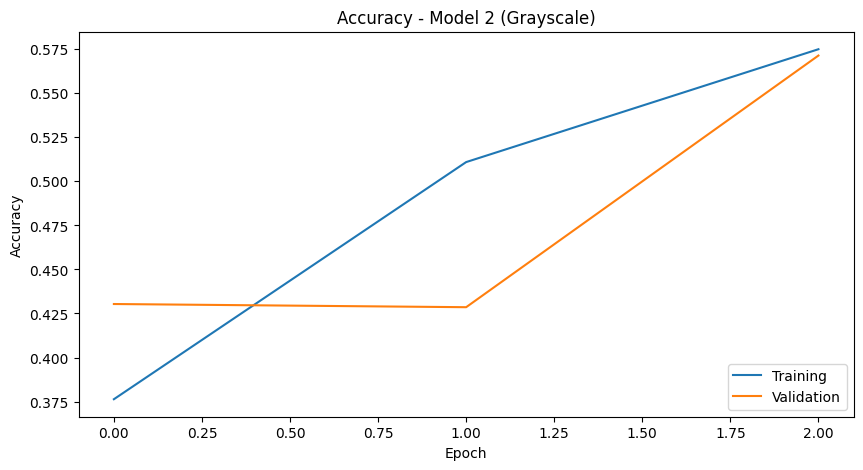

In [32]:
# Plotting the accuracies

plt.figure(figsize = (10, 5))
plt.plot(history_2_grayscale.history['accuracy'])
plt.plot(history_2_grayscale.history['val_accuracy'])
plt.title('Model Accuracy - Grayscale1')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the Model on the Test Set**

In [34]:
accuracy = cnn2_gray.evaluate(test_set_grayscale)

4/4 [==============================] - 1s 207ms/step - loss: 0.9574 - accuracy: 0.5156


**Observations and Insights:**<br>
As constructed, our second, deeper grayscale model performs somewhat differently than its predecessor. After 18 epochs (best epoch), training accuracy stands at 0.78 and validation accuracy is 0.71, which are both higher than Model 1, but Model 2 begins to overfit almost immediately, and the gaps between training and accuracy scores only grow from there. Training accuracy and loss continue to improve, while validation accuracy and loss begin to level off before early-stopping ends the training process. Accuracy on the test set is 0.69. Our model is not generalizing well, though with better accuracy scores compared to Model 1, there is an opportunity (if overfitting can be reduced) to become the better grayscale model.




|  | Training | Validation | Test |
| --- | --- | --- | --- |
|  Grayscale Accuracy |0.78 | 0.71 | 0.69 |
<br>


**Overall Observations and Insights on Initial Models:**<br>

* As discussed above, both grayscale models slightly outperformed their RGB counterparts, and did so using less trainable parameters, making them less computationally expensive. Given this performance, we will proceed with grayscale models when doing so is possible.
* As the datasets for this project are black and white images, it is possible that a grayscale colormode works better than a RGB colormode on what are essentially grayscale images. In this case, adding a second and third channel and increasing the input shape from 48,48,1 to 48,48,3 does not seem to help the modeling, and in fact may be making it overly complex.
* As evidenced by the graph below, the 4 models thus far have fairly similar accuracy trajectories, though with a fair degree of separation between them. There is obviously room for improvement when it comes to overall accuracy. As early-stopping has prohibited us from seeing whether or not the training accuracy and loss level off before reaching 100%, it is clear that they continue to improve while validation accuracy and loss level off.
* Some possible ways to decrease overfitting and thereby improve the above models include:
    * Introduce additional forms of data augmentation. While the above models take advantage of **horizontal_flip**, **brightness_range**, **rescale**, and **sheer_range**, it is possible that introducing additional forms of data augmentation (like **width_shift_range**, **height_shift_range**, **zoon_range**, **rotation_range**, etc. as discussed above) could help improve model performance.
    * Additional use **BatchNormalization** could also improve performance by offering some degree of regularization.
    * Additional use of **DropOut** and **SpatialDropout** could also help improve performance by assisting in regularization.
    * Introducting **GaussianNoise** could also assist in regularization, adding a form of noise to the data.

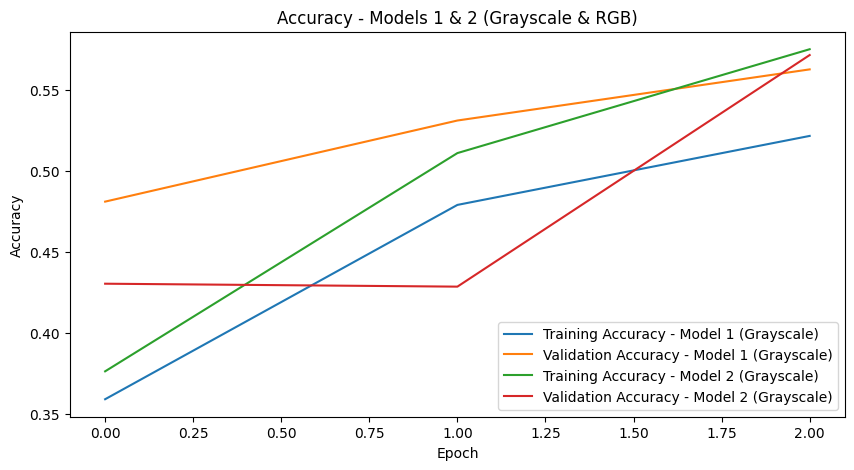

In [35]:
# Plotting the accuracies
plt.figure(figsize = (10, 5))
plt.plot(history_1_grayscale.history['accuracy'])
plt.plot(history_1_grayscale.history['val_accuracy'])
plt.plot(history_2_grayscale.history['accuracy'])
plt.plot(history_2_grayscale.history['val_accuracy'])
plt.title('Model Accuracy - Grayscale1&2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy - Model 1 (Grayscale)',
            'Validation Accuracy - Model 1 (Grayscale)',
            'Training Accuracy - Model 2 (Grayscale)',
            'Validation Accuracy - Model 2 (Grayscale)'], loc='upper left')
plt.show()

## **Transfer Learning Architectures**

In this section, we will create several Transfer Learning architectures. For the pre-trained models, we will select three popular architectures, namely: VGG16, ResNet v2, and Efficient Net. The difference between these architectures and the previous architectures is that these will require 3 input channels (RGB) while the earlier models also worked on grayscale images.


### **Creating our Data Loaders for Transfer Learning Architectures**

We will create new data loaders for the transfer learning architectures used below. As required by the architectures we will be piggybacking, color_mode will be set to RGB.<br>

Additionally, we will be using the same data augmentation methods used on our previous models in order to better compare performance against our baseline models. These methods include **horizontal_flip**, **brightness_range**, **rescale**, and **shear_range**.


In [36]:
batch_size  = 32

# Creating ImageDataGenerator objects for RGB colormode
datagen_train_rgb = ImageDataGenerator(horizontal_flip = True,
                                       brightness_range = (0.,2.),
                                       rescale = 1./255,
                                       shear_range = 0.3)

datagen_validation_rgb = ImageDataGenerator(horizontal_flip = True,
                                            brightness_range = (0.,2.),
                                            rescale = 1./255,
                                            shear_range = 0.3)

datagen_test_rgb = ImageDataGenerator(horizontal_flip = True,
                                      brightness_range = (0.,2.),
                                      rescale = 1./255,
                                      shear_range = 0.3)


# Creating train, validation, and test sets for RGB colormode

print("\nColor Images")

train_set_rgb = datagen_train_rgb.flow_from_directory(train_dir,
                        target_size = (img_size, img_size),
                        color_mode = "rgb",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = True)

val_set_rgb = datagen_validation_rgb.flow_from_directory(validation_dir,
                        target_size = (img_size, img_size),
                        color_mode = "rgb",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = False)

test_set_rgb = datagen_test_rgb.flow_from_directory(test_dir,
                        target_size = (img_size, img_size),
                        color_mode = "rgb",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = False)


Color Images
Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


## <span style="color:navy">Model 3: VGG16</span>


First up is the VGG16 model, which is a CNN consisting of 13 convolutional layers, 5 MaxPooling layers, and 3 dense layers. The VGG16 model achieves nearly 93% accuracy on the ImageNet dataset containing 14 million images across 1,000 classes. Clearly, this is much more substantial than our models above.

### **Importing the VGG16 Architecture**

In [37]:
vgg = VGG16(include_top = False, weights = 'imagenet', input_shape = (48, 48, 3))
vgg.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                              

### **Model Building**
We have imported the VGG16 model up to layer 'block4_pool', as this has shown the best performance compared to other layers (discussed below). The VGG16 layers will be frozen, so the only trainable layers will be those we add ourselves. After flattening the input from 'block4_pool', 2 dense layers will be added, followed by a Dropout layer, another dense layer, and BatchNormalization. We will end with a softmax classifier.


In [41]:
#transfer_layer = vgg.get_layer('block5_pool')
transfer_layer = vgg.get_layer('block2_pool')
vgg.trainable = False

# Flatten the input
x = Flatten()(transfer_layer.output)

# Dense layers
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

# Classifier
pred = Dense(4, activation='softmax')(x)

# Initialize the model
vgg16_model = Model(vgg.input, pred)

### **Compiling and Training the VGG16 Model**

In [42]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint('./vgg16_model.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 15,     # This is increased compared to initial models, otherwise training is cut too quickly
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [43]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
vgg16_model.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [44]:
# Fitting model with epochs set to 30
#history_3 = vgg16_model.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 30, callbacks = callbacks_list)
history_3 = vgg16_model.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 3, callbacks = callbacks_list)

Epoch 1/3
473/473 [==============================] - ETA: 0s - loss: 1.3596 - accuracy: 0.3452
Epoch 1: val_accuracy improved from -inf to 0.44605, saving model to ./vgg16_model.h5
473/473 [==============================] - 257s 539ms/step - loss: 1.3596 - accuracy: 0.3452 - val_loss: 1.1996 - val_accuracy: 0.4461 - lr: 0.0010
Epoch 2/3
473/473 [==============================] - ETA: 0s - loss: 1.1356 - accuracy: 0.4814
Epoch 2: val_accuracy improved from 0.44605 to 0.54290, saving model to ./vgg16_model.h5
473/473 [==============================] - 248s 525ms/step - loss: 1.1356 - accuracy: 0.4814 - val_loss: 1.0519 - val_accuracy: 0.5429 - lr: 0.0010
Epoch 3/3
473/473 [==============================] - ETA: 0s - loss: 1.0388 - accuracy: 0.5432
Epoch 3: val_accuracy improved from 0.54290 to 0.55294, saving model to ./vgg16_model.h5
473/473 [==============================] - 220s 466ms/step - loss: 1.0388 - accuracy: 0.5432 - val_loss: 1.0183 - val_accuracy: 0.5529 - lr: 0.0010


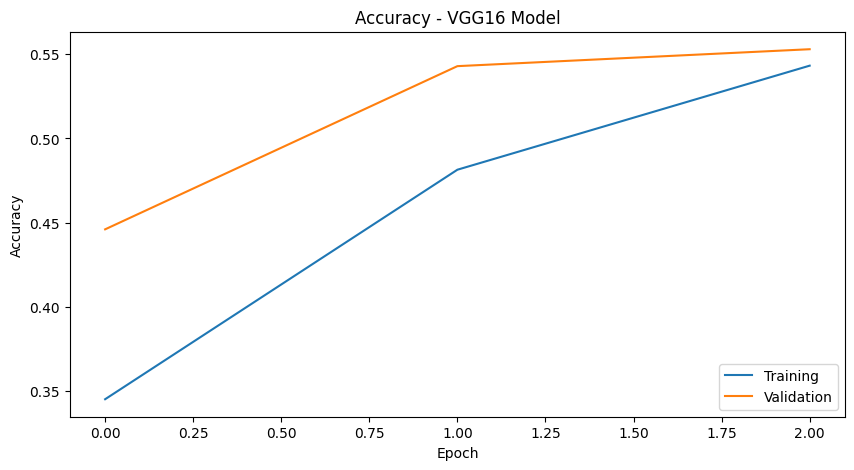

In [46]:
# Plotting the accuracies

plt.figure(figsize = (10, 5))
plt.plot(history_3.history['accuracy'])
plt.plot(history_3.history['val_accuracy'])
plt.title('Model Accuracy - VGG16 Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the VGG16 model**

In [48]:
# Evaluating the model's performance on the test set
accuracy = vgg16_model.evaluate(test_set_rgb)

4/4 [==============================] - 1s 254ms/step - loss: 0.9443 - accuracy: 0.5781


**Observations and Insights:**<br>
As imported and modified, our transfer learning model seems to perform similarly to our previous models developed above. After 29 epochs (best epoch), training accuracy stands at 0.72 and validation accuracy is 0.67. Accuracy and loss for both the training and validation data level off before early stopping ends the training. The model's performance on the test data stands at 0.66. These scores are roughly in line with the scores of Model 1, our baseline model.<br>

The VGG16 model was set up to layer block2_pool, as it produced the best performance. A history of alternative models is below.




|  | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
| --- | --- | --- | --- | --- |
| VGG16 block2_pool |0.71 | 0.72 | 0.80 | 0.67 |
| VGG16 block5_pool |1.05 | 0.54 | 1.10 | 0.52 |

<br>


## <span style="color:navy">Model 4: ResNet v2</span>


Our second transfer learning model is ResNet v2, which is a CNN trained on over 1 million images from the ImageNet database. ResNet v2 can classify images into 1,000 different categories. Like VGG16, colormode must be set to RGB to leverage this pre-trained architecture.

In [49]:
Resnet = ap.ResNet101(include_top = False, weights = "imagenet", input_shape=(48,48,3))
Resnet.summary()

171446536/171446536 [==============================] - 7s 0us/step
Model: "resnet101"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 54, 54, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 24, 24, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 24, 24, 64)           256       ['conv1_conv[0][0]']          
 on)                   

### **Model Building**
We have imported the ResNet v2 model up to layer 'conv_block23_add', as this has shown the best performance compared to other layers (discussed below). The ResNet v2 layers will be frozen, so the only trainable layers will be those we add ourselves. After flattening the input from 'conv_block23_add', we will add the same architecture we did earlier to VGG16, namely 2 dense layers, followed by a DropOut layer, another dense layer, and BatchNormalization. We will once again end with a softmax classifier, as this is a multi-class classification exercise.  

In [50]:
transfer_layer = Resnet.get_layer('conv4_block23_add')
Resnet.trainable = False

# Flatten the input
x = Flatten()(transfer_layer.output)

# Dense layers
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

# Classifier
pred = Dense(4, activation='softmax')(x)

# Initialize the model
model_4 = Model(Resnet.input, pred)

### **Compiling and Training the Model**

In [51]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint('./model_4.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 15,    # Increased over initial models otherwise training is cut off too quickly
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [52]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
model_4.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [53]:
# Fitting model with epochs set to 30
#history_4 = model_4.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 30, callbacks = callbacks_list)
history_4 = model_4.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 3, callbacks = callbacks_list)

Epoch 1/3
473/473 [==============================] - ETA: 0s - loss: 1.4541 - accuracy: 0.2551
Epoch 1: val_accuracy improved from -inf to 0.16014, saving model to ./model_4.h5
473/473 [==============================] - 333s 682ms/step - loss: 1.4541 - accuracy: 0.2551 - val_loss: 1.4336 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 2/3
473/473 [==============================] - ETA: 0s - loss: 1.4100 - accuracy: 0.2561
Epoch 2: val_accuracy improved from 0.16014 to 0.36669, saving model to ./model_4.h5
473/473 [==============================] - 300s 634ms/step - loss: 1.4100 - accuracy: 0.2561 - val_loss: 1.3784 - val_accuracy: 0.3667 - lr: 0.0010
Epoch 3/3
473/473 [==============================] - ETA: 0s - loss: 1.4030 - accuracy: 0.2547
Epoch 3: val_accuracy did not improve from 0.36669
473/473 [==============================] - 306s 648ms/step - loss: 1.4030 - accuracy: 0.2547 - val_loss: 1.3777 - val_accuracy: 0.2289 - lr: 0.0010


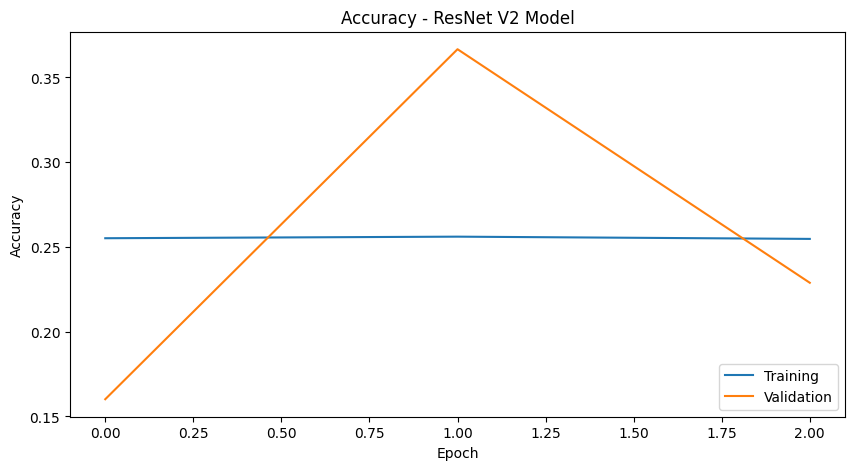

In [54]:
# Plotting the accuracies

plt.figure(figsize = (10, 5))
plt.plot(history_4.history['accuracy'])
plt.plot(history_4.history['val_accuracy'])
plt.title('Model Accuracy - ResNetv2')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the ResNet Model**

In [56]:
# Evaluating the model's performance on the test set
accuracy = model_4.evaluate(test_set_rgb)

4/4 [==============================] - 2s 376ms/step - loss: 1.4119 - accuracy: 0.2500


**Observations and Insights:**<br>
As imported and modified, our transfer learning model shows terrible performance. After just 1 epoch (the 'best' epoch!), training accuracy stands at 0.26 and validation accuracy is 0.36. Accuracy and loss for both training and validation data level off fairly quickly at which point early stopping aborts the training. The above accuracy and loss curves paint the picture of poor model that will not generalize well at all. The model's test accuracy comes in at 0.34.

The ResNet v2 model was ultimately imported up to layer 'conv4_block23_add', as it produced the 'best' performance, though it was difficult to choose. A history of alternative models is below.

|  | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
| --- | --- | --- | --- | --- |
| ResNet V2 conv4_block23_add (selected) |1.43 | 0.26 | 1.35 | 0.36 |
| ResNet V2 conv5_block3_add |1.47 | 0.23 | 1.43 | 0.33 |
| ResNet V2 conv3_block4_add |1.49 | 0.22 | 1.44 | 0.33 |
| ResNet V2 conv2_block3_add |1.51 | 0.21 | 1.55 | 0.21 |

<br>

## <span style="color:navy">Model 5: EfficientNet</span>


Our third transfer learning model is EfficientNet, which is a CNN that uses 'compound scaling' to improve efficiency and, theoretically at least, performance. Like VGG16 and ResNet v2, color_mode must be set to RGB to leverage this pre-trained architecture.

In [57]:
EfficientNet = ap.EfficientNetV2B2(include_top=False, weights="imagenet", input_shape= (48, 48, 3))
EfficientNet.summary()

35839040/35839040 [==============================] - 2s 0us/step
Model: "efficientnetv2-b2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 48, 48, 3)]          0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 48, 48, 3)            0         ['input_3[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 48, 48, 3)            0         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 stem_conv (Conv2

### **Model Building**
We have imported the EfficientNet Model up to layer 'block5f_expand_activation', as this has shown the best performance compared to other layers (discussed below). The EfficientNet layers will be frozen, so the only trainable layers will be those that we add ourselves. After flattening the input from 'block5f_expand_activation', we will add the same architecture we did earlier to the VGG16 and ResNet v2 models, namely 2 dense layers, followed by a Dropout layer, another dense layer, and BatchNormalization. We will end with a softmax classifier.


In [58]:
transfer_layer_EfficientNet = EfficientNet.get_layer('block5f_expand_activation')
EfficientNet.trainable = False

# Flatten the input
x = Flatten()(transfer_layer_EfficientNet.output)

# Dense layers
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)

# Classifier
pred = Dense(4, activation='softmax')(x)

# Initialize the model
model_5 = Model(EfficientNet.input, pred)

### **Compiling and Training the Model**

In [59]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint('./model_5.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 12,
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [60]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
model_5.compile(optimizer = Adam(learning_rate = 0.001), loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [61]:
# Fitting model with epochs set to 30
#history_5 = model_5.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 30, callbacks = callbacks_list)
history_5 = model_5.fit(train_set_rgb, validation_data = val_set_rgb, epochs = 3, callbacks = callbacks_list)

Epoch 1/3
473/473 [==============================] - ETA: 0s - loss: 1.4601 - accuracy: 0.2528
Epoch 1: val_accuracy improved from -inf to 0.16014, saving model to ./model_5.h5
473/473 [==============================] - 97s 188ms/step - loss: 1.4601 - accuracy: 0.2528 - val_loss: 1.5377 - val_accuracy: 0.1601 - lr: 0.0010
Epoch 2/3
473/473 [==============================] - ETA: 0s - loss: 1.4096 - accuracy: 0.2610
Epoch 2: val_accuracy improved from 0.16014 to 0.26783, saving model to ./model_5.h5
473/473 [==============================] - 88s 186ms/step - loss: 1.4096 - accuracy: 0.2610 - val_loss: 1.3562 - val_accuracy: 0.2678 - lr: 0.0010
Epoch 3/3
473/473 [==============================] - ETA: 0s - loss: 1.3994 - accuracy: 0.2527
Epoch 3: val_accuracy improved from 0.26783 to 0.36669, saving model to ./model_5.h5
473/473 [==============================] - 93s 196ms/step - loss: 1.3994 - accuracy: 0.2527 - val_loss: 1.3533 - val_accuracy: 0.3667 - lr: 0.0010


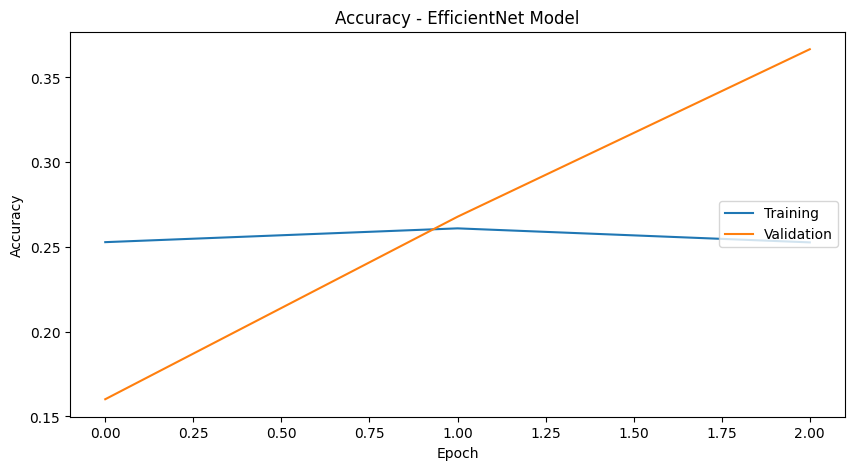

In [62]:
# Plotting the accuracies

plt.figure(figsize = (10, 5))
plt.plot(history_5.history['accuracy'])
plt.plot(history_5.history['val_accuracy'])
plt.title('Model Accuracy - EfficientNet')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='center right')
plt.show()

### **Evaluating the EfficientNet Model**

In [64]:
# Evaluating the model's performance on the test set
accuracy = model_5.evaluate(test_set_rgb)

4/4 [==============================] - 1s 94ms/step - loss: 1.4285 - accuracy: 0.2500


**Observations and Insights:**<br>
As imported and modified, this model performs poorly. After just 4 epochs (the 'best' epoch), training accuracy stands at 0.26 and validation accuracy is 0.24. Training and validation accuracy are almost immediately horizontal. Loss declines a bit before leveling off. With test accuracy coming in at 0.25, it makes the model no better than random guessing. We could build a model that classifies every single image as 'happy', and with our evenly distributed test set, it would produce the same 0.25 accuracy as our EfficientNet model.

Again, it was difficult to select a 'best' layer from which to import the EfficientNet model. A history of alternative models is below.


|  | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
| --- | --- | --- | --- | --- |
| EfficientNet block5f_expand_activation (selected) |1.39 | 0.26 | 1.37 | 0.24 |
| EfficientNet block6e_expand_activation |1.53 | 0.25 | 1.45 | 0.22 |
| EfficientNet block4a_expand_activation |1.42 | 0.25 | 1.42 | 0.21 |
| EfficientNet block3c_expand_activation |1.47 | 0.26 | 1.44 | 0.22 |

<br>


**Overall Observations and Insights on Transfer Learning Models:**<br>
* As outlined above, the performance of these transfer learning models varied greatly. While the VGG16 model performed admirably (see table below), the ResNet v2 and EfficientNet models left much to be desired in terms of stability and performance.
* On the whole, none of the transfer learning models performed better than our baseline and 2nd generation models, which was surprising.
* Model complexity seems to have played a role in performance, as the VGG16 model has a much less complex architecture than both the ResNet v2 and the EfficientNet models. Perhaps overly-complex models trained on millions of large, color images do not perform as well on smaller, black and white images from just 4 classes.
    * VGG16, with 14.7 million parameters, is a fairly straightforward architecture, with just 19 layers from the input layer to the max import layer, 'block5_pool'.
    * ResNet v2, with 42.7 million parameters, is a much more complex architecture, with a whopping 345 layers from the input layer to the max import layer, 'conv5_block3_out'.
    * EfficientNet, with 'just' 8.8 million parameters, contains 349 layers from the input layer to the max import layer, 'top_activation'.
* As evidenced by the table below, it would appear that the unsatisfactory performance of the transfer learning models may have more to do with their complexity than the fact that they require a colormode of RGB. The baseline and 2nd generation RGB models both performed just as well as the VGG16 model. It would seem that the downfall of ResNet v2 and EfficientNet was their complex architecture. Quite simply, the simpler models performed better. In fact, the highest performing model so far, the 2nd generation grayscale model (Model 2.1), has the smallest number of parameters.
* Perhaps a sweet spot exists somewhere between the simplicity of our 2nd generation grayscale model and the much more complex transfer learning models we have explored thus far. If it is possible to increase the complexity of our 2nd generation grayscale model while keeping the overall complexity from ballooning too far in the direction of the transfer learning models, we may find ourselves a successful model.
    

|  | Parameters | Train Loss | Train Accuracy | Val Loss | Val Accuracy | Test Accuracy |
| --- | --- | --- | --- | --- | --- | --- |
| **Model 1.1**: Baseline Grayscale | 605,060 | 0.68 | 0.72 | 0.78 | 0.68 | 0.65 |
| **Model 1.2**: Baseline RGB | 605,572 | 0.68 | 0.72 | 0.78 | 0.68 | 0.63 |
| **Model 2.1**: 2nd Gen Grayscale | 455,780 | 0.54 | 0.78 | 0.74 | 0.71 | 0.69 |
| **Model 2.2**: 2nd Gen RGB | 457,828 | 0.59 | 0.76 | 0.72 | 0.71 | 0.68 |
| **Model 3**: VGG16 | 14,714,688 | 0.71 | 0.72 | 0.80 | 0.67 | 0.66 |
| **Model 4**: ResNet V2 | 42,658,176 | 1.43 | 0.26 | 1.35 | 0.36 | 0.28 |
| **Model 5**: EfficientNet | 8,769,374 | 1.39 | 0.26 | 1.37 | 0.24 | 0.25 |

<br>

# <span style="color:navy">Milestone 1</span>
## <span style="color:navy">CNN 3: Enhance Neural Network Architecture</span>


As previewed above, it is time to expand our 2nd generation grayscale model to see if we can improve performance. Grayscale slightly outperformed RGB in our first two models, so we will leave RGB behind and proceed with color_mode set to grayscale.


## **Creating our Data Loaders**

As we are proceeding with a colormode set to grayscale, we will create new data loaders for our more complex CNN, CNN 3. As our data augmentation takes place when we instantiate an ImageDataGenerator object, it is convenient to create data loaders specific to our new model so we can easily finetune our hyperparameters as needed. The ImageDataGenerators below include the parameters of the final Milestone 1 model, the highest performing CNN thus far. They were chosen after exhaustive finetuning of the model, as discussed later.<br>
* Batch size is set to 32. The model was tested with batch sizes of 16, 32, 45, 64, and 128. A batch size of 32 performed the best. The smaller the batch size, the longer training took. The larger the batch size, the faster the training process, though the accuracy and loss bounced around significantly, offsetting the increased speed.
* **horizontal_flip** is set to 'True'. As some faces in the images face left while others face right or straight ahead, flipping the training images improves our model's ability to learn that horizontal orientation should not affect the eventual classification.
* **rescale** is equal to 1./255, which normalizes the pixel values to a number between 0 and 1. This helps to prevent vanishing and exploding gradients in our network by keeping the numbers small and manageable.
* **brightness_range** is set to '0.7,1.3'. A setting of 1 results in images remaining unchanged. As the number approaches zero, the images become darker. As the number approaches 2, the images become lighter. As many of the images are already very dark or very light, limiting this setting to a relatively small range around 1 will help our model learn to deal with varying pixel values without rendering some images completely unusable.
* **rotation_range** is set to 25, meaning the images may randomly be rotated up to 25 degrees. Similar to flipping the images horizontally, this rotation will help the model learn that the angle of a face is not an important feature.
* Additional data augmentation methods were attempted and later removed after failing to significantly improve model performance. Among those tested were **width_shift_range**, **height_shift_range**, **shear_range**, and **zoom_range**.

In [65]:
batch_size  = 32

# Creating ImageDataGenerator objects for grayscale colormode
datagen_train_grayscale = ImageDataGenerator(horizontal_flip = True,
                                             rescale = 1./255,
                                             brightness_range = (0.7,1.3),
                                             rotation_range=25)

datagen_validation_grayscale = ImageDataGenerator(horizontal_flip = True,
                                                  rescale = 1./255,
                                                  brightness_range = (0.7,1.3),
                                                  rotation_range=25)

datagen_test_grayscale = ImageDataGenerator(horizontal_flip = True,
                                            rescale = 1./255,
                                            brightness_range = (0.7,1.3),
                                            rotation_range=25)


# Creating train, validation, and test sets for grayscale colormode

print("Grayscale Images")

train_set_grayscale = datagen_train_grayscale.flow_from_directory(train_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = True)

val_set_grayscale = datagen_validation_grayscale.flow_from_directory(validation_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = True)

test_set_grayscale = datagen_test_grayscale.flow_from_directory(test_dir,
                        target_size = (img_size, img_size),
                        color_mode = "grayscale",
                        batch_size = batch_size,
                        class_mode = 'categorical',
                        classes = ['happy', 'sad', 'neutral', 'surprise'],
                        seed = 42,
                        shuffle = True)


Grayscale Images
Found 15109 images belonging to 4 classes.
Found 4977 images belonging to 4 classes.
Found 128 images belonging to 4 classes.


### **Model Building**

The structure of the Milestone 1 model (CNN 3) is below. Many configurations were tested, and the following architecture led to the best performance.
* The model begins with an input layer accepting an input shape of '48,48,1', given that our color_mode has been set to grayscale.
* There are 5 convolutional blocks with relu activation. Each block contains BatchNormalization, LeakyReLU, and MaxPooling layers. The first, second, and fourth blocks include a layer of GaussianNoise, while the third and fifth layers each include a Dropout layer.
* The output of the fifth convolutional block is then flattened, and fed into 2 dense layers which include additional BatchNormalization and Dropout layers.
* The architecture is completed with a softmax classifier, as this model is designed for multi-class classification. Test images will be classified as either happy, sad, neutral, or surprise.
* The model contains 2.1 million parameters, making it more complex than our 2nd generation grayscale model, but not as complex as the transfer learning models, whose complexity appeared to hurt their performance.


In [66]:
# Creating a Sequential model
cnn3 = Sequential()

# Convolutional Block #1
cnn3.add(Conv2D(64, (3, 3), input_shape = (48, 48, 1), activation='relu', padding = 'same'))
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
cnn3.add(GaussianNoise(0.1))

# Convolutional Block #2
cnn3.add(Conv2D(128, (3, 3), activation='relu', padding = 'same'))
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
cnn3.add(GaussianNoise(0.1))

# Convolutional Block #3
cnn3.add(Conv2D(512, (2, 2), activation='relu', padding = 'same'))
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
cnn3.add(Dropout(0.1))

# Convolutional Block #4
cnn3.add(Conv2D(512, (2, 2), activation='relu', padding = 'same'))
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
cnn3.add(GaussianNoise(0.1))

# Convolutional Block #5
cnn3.add(Conv2D(256, (2, 2), activation='relu', padding = 'same'))
cnn3.add(BatchNormalization())
cnn3.add(LeakyReLU(alpha = 0.1))
cnn3.add(MaxPooling2D(2, 2))
cnn3.add(Dropout(0.1))

# Flatten layer
cnn3.add(Flatten())

# Dense layers
cnn3.add(Dense(256, activation = 'relu'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.1))

cnn3.add(Dense(512, activation = 'relu'))
cnn3.add(BatchNormalization())
cnn3.add(Dropout(0.05))

# Classifier
cnn3.add(Dense(4, activation = 'softmax'))

cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 48, 48, 64)        640       
                                                                 
 batch_normalization_8 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 gaussian_noise (GaussianNo  (None, 24, 24, 64)        0         
 ise)                                                            
                                                      

### **Compiling and Training the Model**

In [67]:
# Creating a checkpoint which saves model weights from the best epoch
checkpoint = ModelCheckpoint('./cnn3.h5', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto')

# Initiates early stopping if validation loss does not continue to improve
early_stopping = EarlyStopping(monitor = 'val_loss',
                              min_delta = 0,
                              patience = 10,
                              verbose = 1,
                              restore_best_weights = True)

# Initiates reduced learning rate if validation loss does not continue to improve
reduce_learningrate = ReduceLROnPlateau(monitor = 'val_loss',
                                        factor = 0.2,
                                        patience = 3,
                                        verbose = 1,
                                        min_delta = 0.0001)

callbacks_list = [checkpoint, early_stopping, reduce_learningrate]

In [68]:
# Compiling model with optimizer set to Adam, loss set to categorical_crossentropy, and metrics set to accuracy
cnn3.compile(optimizer = 'Adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])


In [ ]:
# Fitting model with epochs set to 30
#history_6 = cnn3.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 30, callbacks = callbacks_list)
history_6 = cnn3.fit(train_set_grayscale, validation_data = val_set_grayscale, epochs = 3, callbacks = callbacks_list)

Epoch 1/3
473/473 [==============================] - ETA: 0s - loss: 1.4575 - accuracy: 0.3485
Epoch 1: val_accuracy improved from -inf to 0.36307, saving model to ./model_6.h5
473/473 [==============================] - 424s 890ms/step - loss: 1.4575 - accuracy: 0.3485 - val_loss: 1.6683 - val_accuracy: 0.3631 - lr: 0.0010
Epoch 2/3
285/473 [=================>............] - ETA: 2:38 - loss: 1.2150 - accuracy: 0.4473

In [ ]:
# Plotting the accuracies

plt.figure(figsize = (10, 5))
plt.plot(history_6.history['accuracy'])
plt.plot(history_6.history['val_accuracy'])
plt.title('Model Accuracy - Enhanced CNN Model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

### **Evaluating the Model on Test Set**

In [ ]:
# Evaluating the model's performance on the test set
accuracy = cnn3.evaluate(test_set_grayscale)

**Observations and Insights:**<br>
CNN 3, our Milestone 1 model, outperforms all previous models. After 33 epochs (best epoch), training accuracy stands at 0.79 and validation accuracy is 0.76. Accuracy and loss for both training and validation data improve similarly before leveling off. The model begins to overfit around epoch 15, but the overfitting is not as severe as previous models. The test accuracy for this model is 0.76. Overall, CNN 3 generalizes better than previous models, and is the top performer thus far. That said, **it is still an overfitting model, and thus it would not be advisable to deploy this model as is**.

This model underwent numerous transformations before arriving at its final state. Parameters were tuned, layers were added, layers were removed, and eventually the above model was determined to be the best iteration. An abridged history of model development can be found in the table below.

The starting point for our final model was as follows:

**CONVOLUTIONAL BLOCK #1**
* Conv2D(64,(2,2), input shape = (48,48,1), activation = 'relu', padding = 'same')
* BatchNormalization
* LeakyReLU(alpha = 0.1)
* MaxPooling2D(2,2)<br>


**CONVOLUTIONAL BLOCK #2**
* Conv2D(128,(2,2), activation = 'relu', padding = 'same')
* BatchNormalization
* LeakyReLU(alpha = 0.1)
* MaxPooling2D(2,2)<br>


**CONVOLUTIONAL BLOCK #3**
* Conv2D(512,(2,2), activation = 'relu', padding = 'same')
* BatchNormalization
* LeakyReLU(alpha = 0.1)
* MaxPooling2D(2,2)<br>


**CONVOLUTIONAL BLOCK #4**
* Conv2D(256,(2,2), activation = 'relu', padding = 'same')
* BatchNormalization
* LeakyReLU(alpha = 0.1)
* MaxPooling2D(2,2)<br>


**CONVOLUTIONAL BLOCK #5**
* Conv2D(128,(2,2), activation = 'relu', padding = 'same')
* BatchNormalization
* LeakyReLU(alpha = 0.1)
* MaxPooling2D(2,2)<br>


**FINAL LAYERS**
* Flatten
* Dense(256, activation = 'relu')
* Dropout(0.1)
* Dense(256, activation = 'relu')
* Dropout(0.1)
* Dense(4, activation = 'softmax')


**PARAMETERS**
* Batch size = 32
* horizontal_flip = True
* rescale = 1./255
* brightness_range = (0.0,2.0)
* shear_range = 0.3


Below is an abridged summary of actions taken to improve the model. In many cases, parameters or layers were adjusted, added, or removed, just to be returned to their original state when the desired or experimental impact was not realized. The model went through dozens of iterations, with the following transformations being the most impactful.  

|  Action Taken | Train Loss | Train Accuracy | Val Loss | Val Accuracy |
| --- | --- | --- | --- | --- |
| Starting model as outlined above | 0.77 | 0.70 | 0.89 | 0.58 |
| Dropout(0.1) layers added to conv blocks 1 and 5 to reduce overfitting |0.75 | 0.74 | 0.66 | 0.61 |
| Shear_range removed entirely to determine effect |0.76 | 0.74 | 0.68 | 0.60 |
| Rotation_range added and optimized |0.74 | 0.74 | 0.62 | 0.61 |
| Additional dropout layers added to blocks 2 and 4 |0.59 | 0.78 | 0.64 | 0.68 |
| Number of neurons in final dense layer set to 512 |0.68 | 0.71 | 0.62 | 0.71 |
| Number of neurons in block 4 increased to 512 |0.70 | 0.73 | 0.60 | 0.74 |
| Dropout layers swapped out for GaussianNoise in blocks 1 and 2 |0.61 | 0.74 | 0.57 | 0.75 |
| Brightness_range narrowed to (0.5,1.5) then to (0.7,1.3) |0.59 | 0.75 | 0.60 | 0.75 |
| Kernel size enlarged to 3x3 in first then also second block |0.55 | 0.78 | 0.57 | 0.75 |
| Dropout in block 5 reduced to 0.5, resulting in final model |0.54 | 0.79 | 0.60 | 0.76 |

<br>


### **Model Comparison**

Below are the accuracy and loss scores for each of our models, first in a tabular format, then represented visually in the form of bar charts.

|  | Parameters | Train Loss | Train Accuracy | Val Loss | Val Accuracy | Test Loss | Test Accuracy |
| --- | --- | --- | --- | --- | --- | --- | --- |
| **Model 1**: Grayscale 1 | 605,060 | 0.68 | 0.72 | 0.78 | 0.68 | 0.82 | 0.65 |
| **Model 2**: Grayscale 2 | 455,780 | 0.54 | 0.78 | 0.74 | 0.71 | 0.81 | 0.69 |
| **Model 3**: VGG16 | 14,714,688 | 0.71 | 0.72 | 0.80 | 0.67 | 0.74 | 0.66 |
| **Model 4**: ResNet V2 | 42,658,176 | 1.43 | 0.26 | 1.35 | 0.36 | 1.40 | 0.28 |
| **Model 5**: EfficientNet | 8,769,374 | 1.39 | 0.26 | 1.37 | 0.24 | 1.40 | 0.25 |
| **CNN 3**: Milestone 1 | 2,119,172| 0.54 | 0.79 | 0.60 | 0.76 | 0.56 | 0.76 |





### **Visualizing Images: Actual Class Label vs Predicted Class Label**

In [ ]:
# Making predictions on the test data
y_pred_test = model_7.predict(test_set)

# Converting probabilities to class labels
y_pred_test_classes = np.argmax(y_pred_test, axis = 1)

# Calculating the probability of the predicted class
y_pred_test_max_probas = np.max(y_pred_test, axis = 1)

classes = ['happy', 'sad', 'neutral', 'surprise']

rows = 3

cols = 4

fig = plt.figure(figsize = (12, 12))

for i in range(cols):

    for j in range(rows):
        random_index = np.random.randint(0, len(test_labels))       # generating random integer

        ax = fig.add_subplot(rows, cols, i * rows + j + 1)

        ax.imshow(test_images[random_index, :])                     # selecting random test image

        pred_label = classes[y_pred_test_classes[random_index]]     # predicted label of selected image

        pred_proba = y_pred_test_max_probas[random_index]           # probability associated with model's prediction

        true_label = test_labels[random_index]                      # actual class label of selected image

        if true_label[0] == 1:                                      # converting array to class labels
            true_label = "happy"
        elif true_label[1] == 1:
            true_label = "sad"
        elif true_label[2] == 1:
            true_label = "neutral"
        else:
            true_label = "surprise"

        ax.set_title("actual: {}\npredicted: {}\nprobability: {:.3}\n".format(
               true_label, pred_label, pred_proba))

plt.gray()
plt.show()

## **Conclusion:**
6 different convolutional neural networks have been developed, including 3 "original" Convolutional Neural Networks and 3 Transfer Learning models. Observations of the performance of the 6 models have been drawn.

Insert discussion of possible use cases for Facial Emotion Detection.